## Part 0: Notebook and Import Initialization

This section simply involves setting up global variables, the logging level, as well as making all necessary imports that will be used during the model preparation, training, and evaluation. 

In [1]:
file_path = './data/os-100-packet.pcap'
# THE DATA IS FOUND AT THE FOLLOWING LINK: https://drive.google.com/file/d/1hlyGHqCgxPofS0HvCCl-ToKR-XbBtuPV/view?usp=sharing

# Required Module Imports 
import pandas as pd
import numpy as np
from scapy.all import *
import logging
import matplotlib.pyplot as plt
import time

# Required Scikit Learn Imports 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# logging level set to error to avoid excessive warning prints
# in data loading, as it causes slowdown. 
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)

## Part 1: Data Preparation and Processing

The data will be processed by using scapy to read in the IP / TCP headers from the pcap data file. The helper function get_headers is used to perform this loading, and creates an array of dictionaries, where each dictionary consists of the required headers. This datablock takes roughly ~10 minutes to load and is the bottleneck for data initialization and processing. 

In [2]:
# The data will be read in and parsed from the pcap file. 
# Expect this block to take ~ 10 minutes to load in data.

def get_headers(pcap_path, limit = None, print_on = 10000):
    '''
        extracts the IP / TCP headers from the given pcap file.

            Parameters:
                    pcap_path (str): A string file path to the PCAP input file.
                    limit (Optional) (int): Integer limit on number of packets to read in.
                    print_on (Optional, default = 10000) (int): Print time on which load intervals.

            Returns:
                    headers (list): list of ip / tcp header dictionaries
    '''
    # time logging
    start_time = time.time()
    headers = []

    # Lazy read PCAP file
    packets = PcapReader(pcap_path)
    for i, packet in enumerate(packets):
        
        # break on limit, log on interval
        if (limit and i >= limit): break
        if (i and not i % print_on): print(f"Loaded {i} headers in {time.time() - start_time} seconds.")
        header = {}

        if IP in packet:
            # Read the following IP headers:
            header = {
                "ip_version": packet[IP].version,
                "ip_ihl": packet[IP].ihl,
                "ip_tos": packet[IP].tos,
                "ip_tot_len": packet[IP].len,
                "ip_flags": packet[IP].flags,
                "ip_frag_ofs": packet[IP].frag,
                "ip_ttl": packet[IP].ttl,
                "ip_protocol": packet[IP].proto,
                "ip_checksum": packet[IP].chksum,
                "ip_src": packet[IP].src,
                "ip_dst": packet[IP].dst,
            }

        if TCP in packet:
            # Read the following TCP headers:
            header |= {
                "tcp_src": packet[TCP].sport,
                "tcp_dst": packet[TCP].dport,
                "tcp_seq_num": packet[TCP].seq,
                "tcp_ack_num": packet[TCP].ack,
                "tcp_ofs": packet[TCP].dataofs,
                "tcp_flags": packet[TCP].flags,
                "tcp_winsize": packet[TCP].window,
                "tcp_checksum": packet[TCP].chksum,
                "tcp_urgptr": packet[TCP].urgptr,
            }
        
        headers.append(header)

    print(f"Finished reading {i} packets in {time.time() - start_time} seconds.")
    return headers

# Load IP / TCP headers from pcap
headers = get_headers(file_path, print_on=50000)

headers

Loaded 50000 headers in 28.140783071517944 seconds.
Loaded 100000 headers in 50.959389209747314 seconds.
Loaded 150000 headers in 73.66447615623474 seconds.
Loaded 200000 headers in 96.0869152545929 seconds.
Loaded 250000 headers in 119.00119304656982 seconds.
Loaded 300000 headers in 141.80210423469543 seconds.
Loaded 350000 headers in 164.13235306739807 seconds.
Loaded 400000 headers in 186.19003129005432 seconds.
Loaded 450000 headers in 208.98634123802185 seconds.
Loaded 500000 headers in 231.14520812034607 seconds.
Loaded 550000 headers in 253.6852560043335 seconds.
Loaded 600000 headers in 276.42104291915894 seconds.
Loaded 650000 headers in 297.98321413993835 seconds.
Loaded 700000 headers in 320.9354429244995 seconds.
Loaded 750000 headers in 346.2600541114807 seconds.
Loaded 800000 headers in 368.02223801612854 seconds.
Loaded 850000 headers in 389.95030307769775 seconds.
Loaded 900000 headers in 412.81057119369507 seconds.
Loaded 950000 headers in 436.56790018081665 seconds.


[{'ip_version': 4,
  'ip_ihl': 5,
  'ip_tos': 0,
  'ip_tot_len': 40,
  'ip_flags': <Flag 2 (DF)>,
  'ip_frag_ofs': 0,
  'ip_ttl': 128,
  'ip_protocol': 6,
  'ip_checksum': 34042,
  'ip_src': '192.168.10.5',
  'ip_dst': '208.111.178.234',
  'tcp_src': 52240,
  'tcp_dst': 443,
  'tcp_seq_num': 4079572452,
  'tcp_ack_num': 2000888364,
  'tcp_ofs': 5,
  'tcp_flags': <Flag 16 (A)>,
  'tcp_winsize': 1488,
  'tcp_checksum': 43955,
  'tcp_urgptr': 0},
 {'ip_version': 4,
  'ip_ihl': 5,
  'ip_tos': 0,
  'ip_tot_len': 40,
  'ip_flags': <Flag 2 (DF)>,
  'ip_frag_ofs': 0,
  'ip_ttl': 128,
  'ip_protocol': 6,
  'ip_checksum': 34041,
  'ip_src': '192.168.10.5',
  'ip_dst': '208.111.178.234',
  'tcp_src': 52240,
  'tcp_dst': 443,
  'tcp_seq_num': 4079572452,
  'tcp_ack_num': 2000891284,
  'tcp_ofs': 5,
  'tcp_flags': <Flag 16 (A)>,
  'tcp_winsize': 1488,
  'tcp_checksum': 41035,
  'tcp_urgptr': 0},
 {'ip_version': 4,
  'ip_ihl': 5,
  'ip_tos': 0,
  'ip_tot_len': 40,
  'ip_flags': <Flag 2 (DF)>,
  'ip_

In [3]:
# Convert headers to a pandas dataframe
df = pd.DataFrame(headers)

df

,ip_version,ip_ihl,ip_tos,ip_tot_len,ip_flags,ip_frag_ofs,ip_ttl,ip_protocol,ip_checksum,ip_src,ip_dst,tcp_src,tcp_dst,tcp_seq_num,tcp_ack_num,tcp_ofs,tcp_flags,tcp_winsize,tcp_checksum,tcp_urgptr
0,4,5,0,40,DF,0,128,6,34042,192.168.10.5,208.111.178.234,52240,443,4079572452,2000888364,5,A,1488,43955,0
1,4,5,0,40,DF,0,128,6,34041,192.168.10.5,208.111.178.234,52240,443,4079572452,2000891284,5,A,1488,41035,0
2,4,5,0,40,DF,0,128,6,34040,192.168.10.5,208.111.178.234,52240,443,4079572452,2000894204,5,A,1488,38115,0
3,4,5,0,40,DF,0,128,6,34039,192.168.10.5,208.111.178.234,52240,443,4079572452,2000897124,5,A,1488,35195,0
4,4,5,0,40,DF,0,128,6,34038,192.168.10.5,208.111.178.234,52240,443,4079572452,2000900044,5,A,1488,32275,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243895,4,5,0,2075,DF,0,128,6,3786,192.168.10.8,68.67.178.173,51135,80,2372889233,2772019017,5,PA,16425,51630,0
1243896,4,5,0,1500,DF,0,128,6,4359,192.168.10.8,68.67.178.173,51250,80,2435787775,249362882,5,A,16425,20488,0
1243897,4,5,0,614,DF,0,128,6,5244,192.168.10.8,68.67.178.173,51250,80,2435789235,249362882,5,PA,16425,47298,0
1243898,4,5,0,40,DF,0,128,6,62529,192.168.10.8,151.101.130.2,50582,80,576469993,3420470636,5,A,16244,24271,0


In [4]:
# each unique IP address is mapped to the operating system, which is taken 
# from the Intrusion Detection Evaluation Dataset (CIC-IDS2017) mapping

# check how many unique IP addresses there are
np.unique(df["ip_src"])

# map the IP addresses to the OS from the original dataset
ip_to_os = {
    "192.168.10.12": "Ubuntu 16.4, 64B",
    "192.168.10.14": "Win 10, pro 32B",
    "192.168.10.15": "Win 10, 64B",
    "192.168.10.16": "Ubuntu 16.4, 32B",
    "192.168.10.17": "Ubuntu 14.4, 64B",
    "192.168.10.19": "Ubuntu 14.4, 32B",
    '192.168.10.25': "MAC",
    '192.168.10.5': "Win 8.1, 64B",
    '192.168.10.50': "Web server 16 Public",
    '192.168.10.51': "Ubuntu server 12 Public",
    '192.168.10.8': "Windows Vista",
    '192.168.10.9': "Win 7 Pro, 64B",
    '205.174.165.73': "Kali"
}

df["OS"] = df['ip_src'].map(ip_to_os)

df

,ip_version,ip_ihl,ip_tos,ip_tot_len,ip_flags,ip_frag_ofs,ip_ttl,ip_protocol,ip_checksum,ip_src,...,tcp_src,tcp_dst,tcp_seq_num,tcp_ack_num,tcp_ofs,tcp_flags,tcp_winsize,tcp_checksum,tcp_urgptr,OS
0,4,5,0,40,DF,0,128,6,34042,192.168.10.5,...,52240,443,4079572452,2000888364,5,A,1488,43955,0,"Win 8.1, 64B"
1,4,5,0,40,DF,0,128,6,34041,192.168.10.5,...,52240,443,4079572452,2000891284,5,A,1488,41035,0,"Win 8.1, 64B"
2,4,5,0,40,DF,0,128,6,34040,192.168.10.5,...,52240,443,4079572452,2000894204,5,A,1488,38115,0,"Win 8.1, 64B"
3,4,5,0,40,DF,0,128,6,34039,192.168.10.5,...,52240,443,4079572452,2000897124,5,A,1488,35195,0,"Win 8.1, 64B"
4,4,5,0,40,DF,0,128,6,34038,192.168.10.5,...,52240,443,4079572452,2000900044,5,A,1488,32275,0,"Win 8.1, 64B"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243895,4,5,0,2075,DF,0,128,6,3786,192.168.10.8,...,51135,80,2372889233,2772019017,5,PA,16425,51630,0,Windows Vista
1243896,4,5,0,1500,DF,0,128,6,4359,192.168.10.8,...,51250,80,2435787775,249362882,5,A,16425,20488,0,Windows Vista
1243897,4,5,0,614,DF,0,128,6,5244,192.168.10.8,...,51250,80,2435789235,249362882,5,PA,16425,47298,0,Windows Vista
1243898,4,5,0,40,DF,0,128,6,62529,192.168.10.8,...,50582,80,576469993,3420470636,5,A,16244,24271,0,Windows Vista


In [5]:
# the labels are isolated from the dataframe, and extraneous columns are removed
# the removed columns are ones that show no variation at all in the data set (ip version, protocol...etc.)
# other columns that represent unnecessary features that are related to the topography of the 
# network and not actually the OS are also removed (ip source, ip destination, tcp source port, 
# tcp destination port, acknowledgement and sequence number). These columns were also removed
# as suggested by the original paper.

clean_df = df.drop(["ip_version", "ip_ihl", "ip_src", "ip_frag_ofs", "ip_protocol", "ip_dst", 
                    "tcp_src", "tcp_dst", "tcp_seq_num", "tcp_ack_num", "tcp_urgptr", "OS"], axis = 1)
labels = df["OS"]

# convert flags to int to facilitate training
clean_df["ip_flags"] = clean_df['ip_flags'].apply(lambda x: int(x))
clean_df["tcp_flags"] = clean_df['tcp_flags'].apply(lambda x: int(x))

clean_df

,ip_tos,ip_tot_len,ip_flags,ip_ttl,ip_checksum,tcp_ofs,tcp_flags,tcp_winsize,tcp_checksum
0,0,40,2,128,34042,5,16,1488,43955
1,0,40,2,128,34041,5,16,1488,41035
2,0,40,2,128,34040,5,16,1488,38115
3,0,40,2,128,34039,5,16,1488,35195
4,0,40,2,128,34038,5,16,1488,32275
...,...,...,...,...,...,...,...,...,...
1243895,0,2075,2,128,3786,5,24,16425,51630
1243896,0,1500,2,128,4359,5,16,16425,20488
1243897,0,614,2,128,5244,5,24,16425,47298
1243898,0,40,2,128,62529,5,16,16244,24271


In [6]:
# the OS labels are now encoded using the scikit learn LabelEncoder()
# the encoding is performed to convert the string labels to integer types
# that can be used for training and prediciton by the models

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

y_encoded

array([11, 11, 11, ..., 12, 12, 12])

## Part 2: Model Training

In this section, three models are trained on the data, namely the Random Forest Classifier, an MLP Classifier, and a Tree Classifier. Expect training to take around ~5 minutes for the random forest and tree models seperately, and ~10 minutes for MLP before it converges. 

In [7]:
# Train / Test Split, at 20% test size:
X_train, X_test, y_train, y_test = train_test_split(clean_df, y_encoded, test_size=0.2, random_state=42)

In [8]:
# Model 1: Random Forest Classifier (expect this block to take ~3 minutes to train)

random_forest = RandomForestClassifier(n_estimators=50)

random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50)

In [9]:
# Model 2: Neural Network (expect this block to take ~12 minutes to train)

mlp = MLPClassifier(verbose=True)
mlp.fit(X_train, y_train)

Iteration 1, loss = 25.46849490
Iteration 2, loss = 22.23697976
Iteration 3, loss = 20.51024076
Iteration 4, loss = 19.44405533
Iteration 5, loss = 18.40667107
Iteration 6, loss = 17.39462790
Iteration 7, loss = 16.03522335
Iteration 8, loss = 14.53340024
Iteration 9, loss = 12.98673671
Iteration 10, loss = 10.95503534
Iteration 11, loss = 8.79918049
Iteration 12, loss = 6.86314808
Iteration 13, loss = 5.02190232
Iteration 14, loss = 3.34986304
Iteration 15, loss = 1.92539272
Iteration 16, loss = 1.42945087
Iteration 17, loss = 1.39594567
Iteration 18, loss = 1.39256090
Iteration 19, loss = 1.39060602
Iteration 20, loss = 1.38608793
Iteration 21, loss = 1.37584619
Iteration 22, loss = 1.37623760
Iteration 23, loss = 1.36936656
Iteration 24, loss = 1.36811106
Iteration 25, loss = 1.36464427
Iteration 26, loss = 1.36269721
Iteration 27, loss = 1.36273843
Iteration 28, loss = 1.36188526
Iteration 29, loss = 1.36047895
Iteration 30, loss = 1.36363868
Iteration 31, loss = 1.35806969
Iterati

MLPClassifier(verbose=True)

In [10]:
# Model 3: Decision Tree Classifier

clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

## Part 3: Model Evaluation

Model evaluation was performed by calculating accuracy, other metrics such as presicion, recall, f1 score...etc., and feature importance where possible.

0.8038950076372698


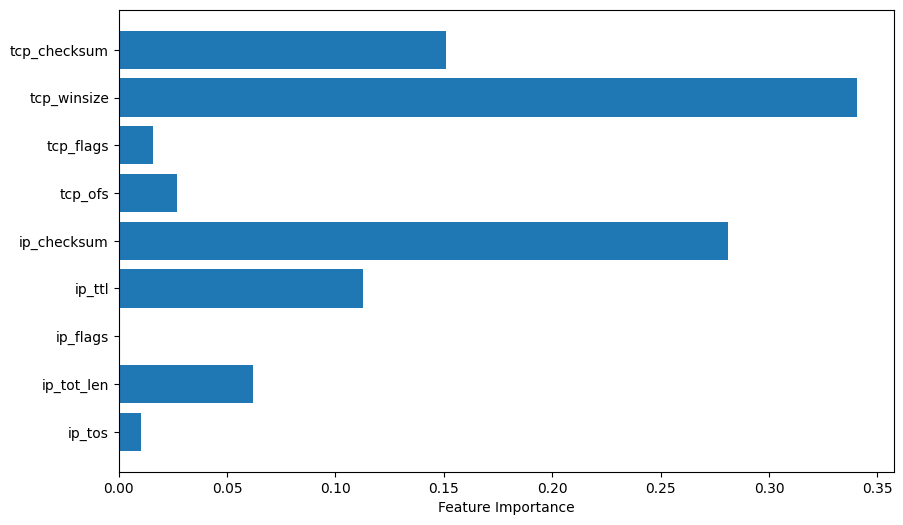

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8702
           1       0.98      0.98      0.98     20115
           2       0.61      0.64      0.63     19993
           3       0.61      0.63      0.62     19982
           4       0.67      0.65      0.66     20126
           5       0.65      0.63      0.64     19925
           6       0.61      0.60      0.61     19863
           7       0.96      0.97      0.96     19933
           8       0.96      0.96      0.96     20172
           9       0.94      0.91      0.93     20090
          10       0.81      0.80      0.80     19987
          11       0.81      0.85      0.83     19788
          12       0.94      0.94      0.94     20104

    accuracy                           0.80    248780
   macro avg       0.81      0.81      0.81    248780
weighted avg       0.80      0.80      0.80    248780



In [11]:
# Model 1: Evaluating Random Forest

# Calculate Accuracy Directly
y_pred = random_forest.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Plot Learned Feature Importance
feature_importance = random_forest.feature_importances_
feature_names = ["ip_tos", "ip_tot_len", "ip_flags", "ip_ttl", "ip_checksum", 
                 "tcp_ofs", "tcp_flags", "tcp_winsize", "tcp_checksum"]
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align="center")
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel("Feature Importance")
plt.show()

# Print Out Full Classification Report
report = classification_report(y_test, y_pred)
print(report)

In [12]:
# Model 2: Evaluating MLP Classifier

# Calculate Accuracy Directly
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Print Out Full Classification Report
report = classification_report(y_test, y_pred)
print(report)

0.3992965672481711
              precision    recall  f1-score   support

           0       0.28      0.91      0.43      8702
           1       0.75      0.96      0.85     20115
           2       0.00      0.00      0.00     19993
           3       0.14      0.01      0.03     19982
           4       0.17      0.64      0.27     20126
           5       0.20      0.07      0.10     19925
           6       0.25      0.01      0.02     19863
           7       0.58      0.29      0.39     19933
           8       0.48      0.39      0.43     20172
           9       0.42      0.51      0.46     20090
          10       0.40      0.47      0.43     19987
          11       0.49      0.22      0.30     19788
          12       0.74      0.98      0.84     20104

    accuracy                           0.40    248780
   macro avg       0.38      0.42      0.35    248780
weighted avg       0.38      0.40      0.35    248780



0.8351716375914463


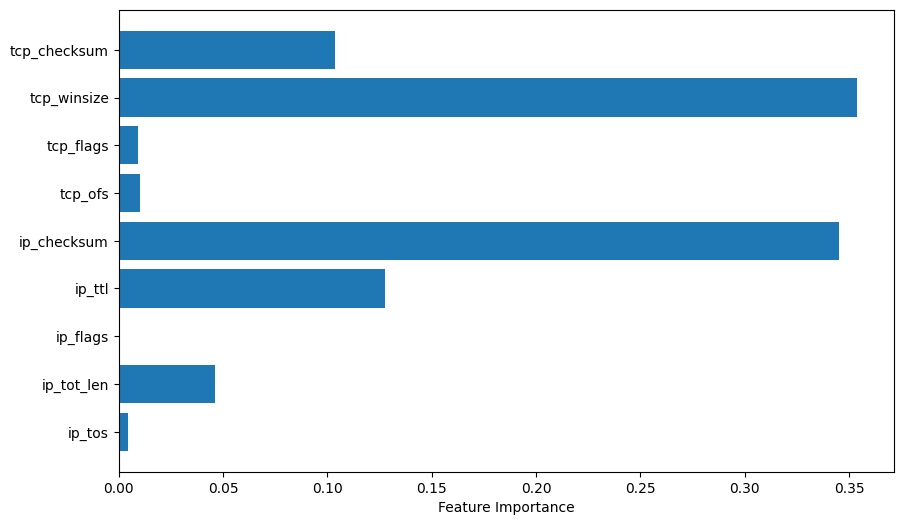

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8702
           1       0.99      0.97      0.98     20115
           2       0.71      0.71      0.71     19993
           3       0.72      0.71      0.71     19982
           4       0.72      0.72      0.72     20126
           5       0.70      0.70      0.70     19925
           6       0.70      0.69      0.70     19863
           7       0.96      0.97      0.96     19933
           8       0.96      0.97      0.96     20172
           9       0.93      0.93      0.93     20090
          10       0.81      0.79      0.80     19987
          11       0.82      0.83      0.83     19788
          12       0.94      0.94      0.94     20104

    accuracy                           0.84    248780
   macro avg       0.84      0.84      0.84    248780
weighted avg       0.84      0.84      0.84    248780



In [13]:
# Model 3: 

# Calculate Accuracy Directly
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# Plot Learned Feature Importance
feature_importance = clf.feature_importances_
feature_names = ["ip_tos", "ip_tot_len", "ip_flags", "ip_ttl", "ip_checksum", 
                 "tcp_ofs", "tcp_flags", "tcp_winsize", "tcp_checksum"]
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align="center")
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel("Feature Importance")
plt.show()

# Print Out Full Classification Report
report = classification_report(y_test, y_pred)
print(report)

## Part 4: Extension
In this section, I try to expand on the original paper, as well as my previous findings to further see if the model accuracy can be improved.

0.8407106680601335


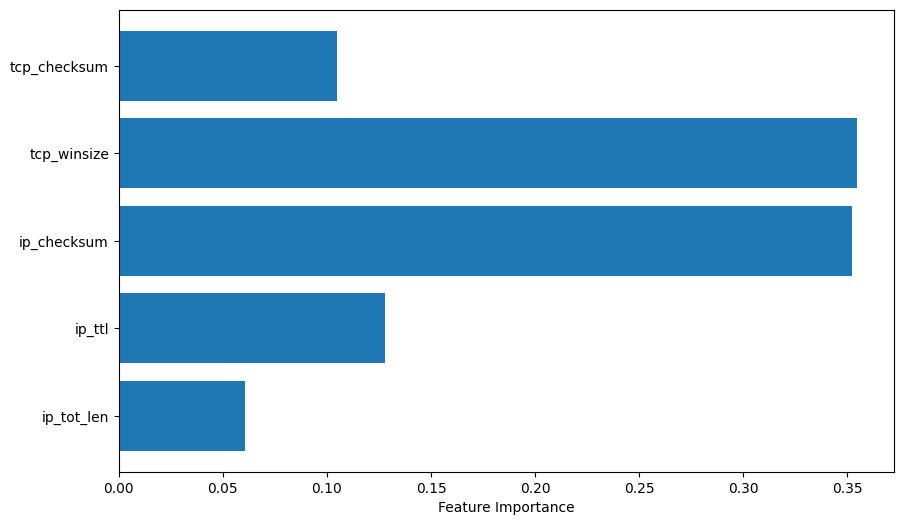

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8702
           1       0.98      0.97      0.98     20115
           2       0.72      0.72      0.72     19993
           3       0.72      0.71      0.72     19982
           4       0.73      0.74      0.73     20126
           5       0.71      0.71      0.71     19925
           6       0.71      0.70      0.71     19863
           7       0.95      0.97      0.96     19933
           8       0.96      0.97      0.96     20172
           9       0.93      0.93      0.93     20090
          10       0.82      0.80      0.81     19987
          11       0.83      0.84      0.84     19788
          12       0.94      0.94      0.94     20104

    accuracy                           0.84    248780
   macro avg       0.85      0.85      0.85    248780
weighted avg       0.84      0.84      0.84    248780



In [14]:
# In this test, I try to remove additional extraneous columns to test if it affects accuracy
tuned_df = clean_df.drop(["tcp_flags", "tcp_ofs", "ip_flags", "ip_tos"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(tuned_df, y_encoded, test_size=0.2, random_state=42)

# I chose to train a second Decision Tree Classifier as it was the best peforming model from the previous tests.
tuned_clf = DecisionTreeClassifier()
tuned_clf.fit(X_train, y_train)

# accuracy calculation
y_pred = tuned_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# new feature importance
feature_importance = tuned_clf.feature_importances_
feature_names = ["ip_tot_len", "ip_ttl", "ip_checksum", "tcp_winsize", "tcp_checksum"]
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align="center")
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel("Feature Importance")
plt.show()

# Print Out Full Classification Report
report = classification_report(y_test, y_pred)
print(report)

In [15]:
# In this test, I decide to train on chunks (groups of 100 packets) at a time to make a single prediction
chunks_df = []
chunk_labels = []

# generate chunks and coalesce into one label (grouped based on ip src so all labels will be the same per group)
for name, group in df.groupby("ip_src"):
    chunks_df.extend([group.iloc[i:i + 100] for i in range(0, len(group), 100)])
    chunk_labels.extend([np.unique(group.iloc[i:i + 100]["OS"]) for i in range(0, len(group), 100)])

# quick verification / visualization
print(chunk_labels[1])
chunks_df[1]

['Ubuntu 16.4, 64B']


,ip_version,ip_ihl,ip_tos,ip_tot_len,ip_flags,ip_frag_ofs,ip_ttl,ip_protocol,ip_checksum,ip_src,...,tcp_src,tcp_dst,tcp_seq_num,tcp_ack_num,tcp_ofs,tcp_flags,tcp_winsize,tcp_checksum,tcp_urgptr,OS
200100,4,5,0,52,DF,0,64,6,33005,192.168.10.12,...,51300,443,996256440,2758719577,8,A,299,19732,0,"Ubuntu 16.4, 64B"
200101,4,5,0,52,DF,0,64,6,44428,192.168.10.12,...,51298,443,4009073217,450723686,8,A,345,27603,0,"Ubuntu 16.4, 64B"
200102,4,5,0,52,DF,0,64,6,57153,192.168.10.12,...,51292,443,188663495,3841085787,8,A,345,34603,0,"Ubuntu 16.4, 64B"
200103,4,5,0,52,DF,0,64,6,49364,192.168.10.12,...,51290,443,274000962,1570117440,8,A,312,7728,0,"Ubuntu 16.4, 64B"
200104,4,5,0,52,DF,0,64,6,52220,192.168.10.12,...,57146,80,1437490717,1042261637,8,A,241,64949,0,"Ubuntu 16.4, 64B"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200195,4,5,0,83,DF,0,64,6,32708,192.168.10.12,...,36518,443,1734515632,2607564360,8,PA,362,29331,0,"Ubuntu 16.4, 64B"
200196,4,5,0,52,DF,0,64,6,32738,192.168.10.12,...,36518,443,1734515663,2607564360,8,FA,362,30436,0,"Ubuntu 16.4, 64B"
200197,4,5,0,83,DF,0,64,6,12764,192.168.10.12,...,44470,443,1629185176,2627521754,8,PA,700,38995,0,"Ubuntu 16.4, 64B"
200198,4,5,0,52,DF,0,64,6,12794,192.168.10.12,...,44470,443,1629185207,2627521754,8,FA,700,5217,0,"Ubuntu 16.4, 64B"


In [16]:
# remove extraneous columns from input data
# flatten 3d dataframe to a 2d array in order to pass in to training
clean_chunks = []
for chunk in chunks_df:
    clean_chunks.append(chunk.drop(["ip_src", "ip_dst", "tcp_src", "tcp_dst", "tcp_ack_num", "tcp_seq_num", "OS", "ip_flags", "tcp_flags"], axis = 1).to_numpy().reshape(-1))

clean_chunks = np.array(clean_chunks)

# encode labels for training
encoded_chunk_labels = label_encoder.fit_transform(chunk_labels)

X_train, X_test, y_train, y_test = train_test_split(clean_chunks, np.array(encoded_chunk_labels), test_size=0.2, random_state=42)

# I chose to train a third Decision Tree Classifier as it was the best peforming model from the previous tests.
chunks_clf = DecisionTreeClassifier()
chunks_clf.fit(X_train, y_train)

# accuracy calculation
y_pred = chunks_clf.predict(X_test)
accuracy = accuracy_score(np.array(y_test), y_pred)
print(accuracy)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5313504823151125
